In [1]:
# To support both python 2 and python 3
# 让这份笔记同步支持 python 2 和 python 3
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
#使用statsmodels便于统计分析数据
import statsmodels.api as sm
import statsmodels.formula.api as smf
#使用sklearn便于预测（机器学习）
from sklearn import linear_model
#使用patsy便于生成模型
import patsy

**9. This question uses the variables dis (the weighted mean of distances
to five Boston employment centers) and nox (nitrogen oxides concen-
tration in parts per 10 million) from the Boston data. We will treat
dis as the predictor and nox as the response.
(a) Use the poly() function to fit a cubic polynomial regression to
predict nox using dis . Report the regression output, and plot
the resulting data and polynomial fits.**

In [3]:
Boston = pd.read_csv("data/Boston.csv")
Boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [4]:
#因为没有找到好pthon的poly函数，直接用多项式拟合
def patsy_model_poly(factor,degree = 2):
    model_poly = factor
    for i in range(2,degree + 1):
        model_poly = model_poly + '+ I(' + factor +  '**{})'.format(str(i))
    return model_poly
fit_1 = smf.ols('nox ~ {}'.format(patsy_model_poly('dis',3)),data = Boston).fit()

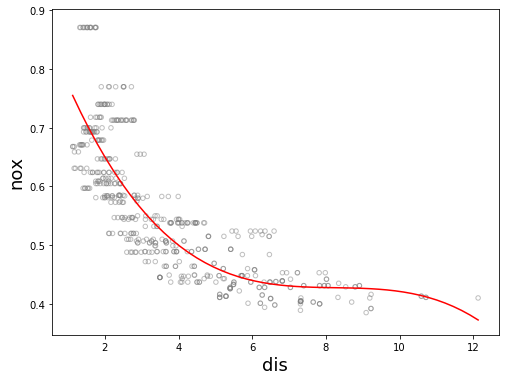

In [5]:
plt.figure(figsize=(8,6))
X_plot = pd.DataFrame({'dis':np.linspace(Boston['dis'].min(),Boston['dis'].max(),50)})
plt.scatter(Boston['dis'],Boston['nox'],color='', marker='o', edgecolors='gray', s=20,alpha = 0.5)
plt.plot(X_plot,fit_1.predict(X_plot),'r')
plt.xlabel('dis',fontsize=18)
plt.ylabel('nox',fontsize=18)
plt.show()

**(b) Plot the polynomial fits for a range of different polynomial
degrees (say, from 1 to 10), and report the associated residual
sum of squares.**

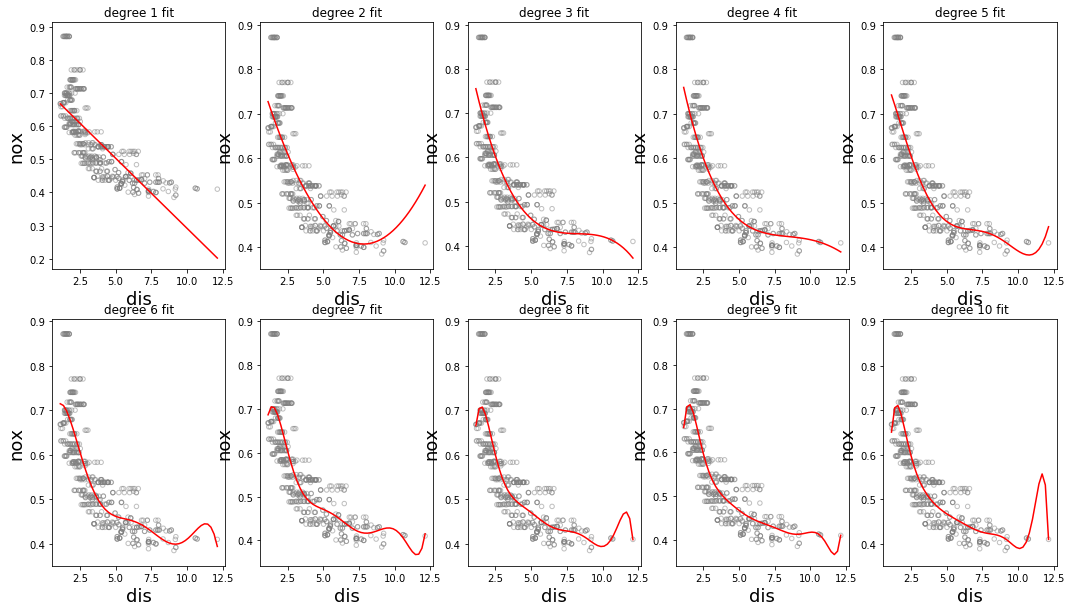

In [6]:
fit_list = []
plt.figure(figsize=(18,10))
for degree in range(1,11):
    fit_list.append(smf.ols('nox ~ {}'.format(patsy_model_poly('dis',degree)),data = Boston).fit())
    plt.subplot(2,5,degree)
    plt.scatter(Boston['dis'],Boston['nox'],color='', marker='o', edgecolors='gray', s=20,alpha = 0.5)
    plt.plot(X_plot,fit_list[degree - 1].predict(X_plot),'r')
    plt.xlabel('dis',fontsize=18)
    plt.ylabel('nox',fontsize=18)
    plt.title('degree {} fit'.format(degree))
plt.show()

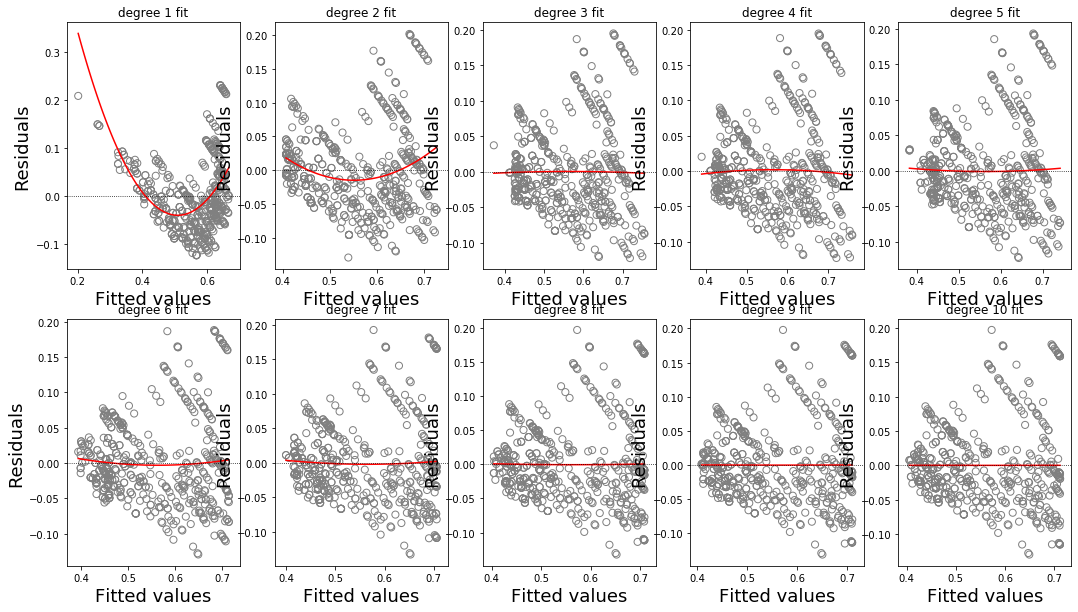

In [7]:
from sklearn.preprocessing import PolynomialFeatures
#sklearn的残差图函数编写，便于后面复用
def plot_Residuals(X_in , y_in,degree_in = 1,degree_Residuals = 2,tap_show = False):    
    poly_features_in = PolynomialFeatures(degree = degree_in,include_bias=False)
    X_degree_in = poly_features_in.fit_transform(np.c_[X_in])
    lin_in = linear_model.LinearRegression()
    lin_in.fit(X_degree_in,y_in)
    y_predict = pd.DataFrame(lin_in.predict(X_degree_in),index = y_in.index,columns = y_in.columns)
    y_Residuals = y_in - y_predict
    poly_features_Residuals = PolynomialFeatures(degree = degree_Residuals,include_bias=False)
    y_predict_poly = poly_features_Residuals.fit_transform(np.c_[y_predict])
    lin_Residuals = linear_model.LinearRegression()
    lin_Residuals.fit(np.c_[y_predict_poly],np.c_[y_Residuals])
    X_new = np.linspace(y_predict.min(), y_predict.max(), 100).reshape(100, 1)
    X_new_poly = poly_features_Residuals.fit_transform(X_new)
    y_new_predict = lin_Residuals.predict(X_new_poly)
    plt.plot(X_new,y_new_predict, "red")
    plt.scatter(y_predict,y_Residuals,color='', marker='o', edgecolors='gray', s=50)
    plt.xlabel("Fitted values", fontsize=18)
    plt.ylabel("Residuals", fontsize=18)
    plt.axhline(y=0,linewidth= 0.8,color = 'black',linestyle=':' )
    if tap_show == True:
        tap_1,tap_2,tap_3 = np.abs(y_Residuals).sort_values(ascending=False).index[:3]
        plt.text(y_predict[tap_1] -2.2, y_Residuals[tap_1] - 0.3, str(tap_1 + 1), fontsize=12, color="black")
        plt.text(y_predict[tap_2] -2.2, y_Residuals[tap_2] - 0.3, str(tap_2 + 1), fontsize=12, color="black")
        plt.text(y_predict[tap_3] -2.2 , y_Residuals[tap_3] - 0.3, str(tap_3 + 1), fontsize=12, color="black") 
y_in,X_in = patsy.dmatrices('nox ~ 0 + dis', data = Boston, return_type="dataframe")
#绘图段
plt.figure(figsize=(18,10))
for degree in range(1,11):
    plt.subplot(2,5,degree)
    plot_Residuals(X_in , y_in,  degree_in = degree)
    plt.title('degree {} fit'.format(degree))

**(c) Perform cross-validation or another approach to select the opti-
mal degree for the polynomial, and explain your results.**

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
pf_lr = Pipeline([
("pf", PolynomialFeatures(include_bias=False)),
("lr", linear_model.LinearRegression())
])
param_grid = [{'pf__degree': np.arange(1,11)}]
grid_search = GridSearchCV(pf_lr, param_grid, cv = 10, scoring='neg_mean_squared_error')
grid_search.fit(X_in ,y_in)

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('pf',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=False,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('lr',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=True,
                                                         n_jobs=None,
                                                         normalize=False))],
                                verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'pf__degree': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])}],
             pre_dispatch='2*n_jobs', refit=Tr

In [9]:
grid_search.best_params_

{'pf__degree': 3}

基本与前面残差图等一致，当dgree=3是残差图无明显特性，此时较差验证最好，此外从预测拟合图上看也最接近散点图分布

**(d) Use the bs() function to fit a regression spline to predict nox
using dis . Report the output for the fit using four degrees of
freedom. How did you choose the knots? Plot the resulting fit.**

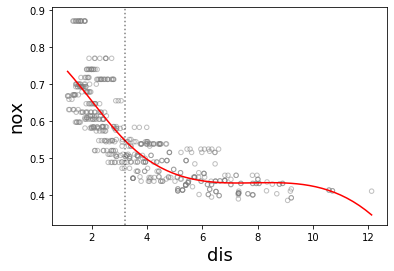

In [10]:
#直接使用df = 4所产生的截断点在均分点处
knots = [Boston['dis'].median()]
fit2 = smf.ols('nox ~ bs(dis, df = 4)',data = Boston).fit()
plt.scatter(Boston['dis'],Boston['nox'],color='', marker='o', edgecolors='gray', s=20,alpha = 0.5)
plt.plot(X_plot,fit2.predict(X_plot),'r')
plt.axvline(knots ,linestyle = ':',color = 'black',alpha = 0.5)
plt.xlabel('dis',fontsize=18)
plt.ylabel('nox',fontsize=18)
plt.show()

**(e) Now fit a regression spline for a range of degrees of freedom, and
plot the resulting fits and report the resulting RSS. Describe the
results obtained.**

In [11]:
#df=1,2,3时实际分别为线性、2次线性、3次线性回归
fit_bs1 = smf.ols('nox ~ dis',data = Boston).fit()
fit_bs2 = smf.ols('nox ~ dis + I(dis ** 2)',data = Boston).fit()
fit_bs3 = smf.ols('nox ~ bs(dis,df = 3)',data = Boston).fit()
fit_bs4 = smf.ols('nox ~ bs(dis,df = 4)',data = Boston).fit()
fit_bs5 = smf.ols('nox ~ bs(dis,df = 5)',data = Boston).fit()
fit_bs6 = smf.ols('nox ~ bs(dis,df = 6)',data = Boston).fit()
fit_bs7 = smf.ols('nox ~ bs(dis,df = 7)',data = Boston).fit()
fit_bs8 = smf.ols('nox ~ bs(dis,df = 8)',data = Boston).fit()
fit_bs9 = smf.ols('nox ~ bs(dis,df = 9)',data = Boston).fit()
fit_bs10 = smf.ols('nox ~ bs(dis,df = 10)',data = Boston).fit()
sm.stats.anova_lm(fit_bs1, fit_bs2, fit_bs3, fit_bs4, fit_bs5, fit_bs6, fit_bs7, fit_bs8, fit_bs9, fit_bs10,typ=1)

c:\users\wujiaxu\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
c:\users\wujiaxu\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\users\wujiaxu\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,504.0,2.768563,0.0,NaN,NaN,NaN
1,503.0,2.035262,1.0,0.733301,202.497587,7.372065e-39
2,502.0,1.934107,1.0,0.101155,27.933518,1.875767e-07
3,501.0,1.922775,1.0,0.011332,3.129199,7.750988e-02
4,500.0,1.840173,1.0,0.082602,22.810203,2.352818e-06
5,499.0,1.833966,1.0,0.006207,1.714006,1.910690e-01
6,498.0,1.829884,1.0,0.004081,1.127075,2.889147e-01
7,497.0,1.816995,1.0,0.012889,3.559344,5.979380e-02
8,496.0,1.825653,1.0,-0.008657,-2.390715,1.000000e+00
9,495.0,1.792535,1.0,0.033118,9.145274,2.623094e-03


随着df上升ssr下降，但df = 5时p值可信

**(f) Perform cross-validation or another approach in order to select
the best degrees of freedom for a regression spline on this data.
Describe your results.**

In [12]:
from sklearn.model_selection import KFold
def model_msr(data,ols_model,dmatrices_model,n_splits,boundary_restrict = False):
    kf = KFold(n_splits=n_splits, random_state=1,shuffle=True)
    kf.get_n_splits(data)
    msr = []
    for train_index, test_index in kf.split(data):
        if boundary_restrict:
            y ,X = patsy.dmatrices(dmatrices_model,data, return_type="dataframe")
            train_index_set= list(train_index)
            if X.idxmax not in train_index:
                train_index_set.append(X.idxmax())
            if X.idxmin not in train_index:
                train_index_set.append(X.idxmin())
            results = smf.ols(ols_model , data = data.iloc[train_index_set]).fit()
        else:
            results = smf.ols(ols_model , data = data.iloc[train_index]).fit()
        y_test ,X_test = patsy.dmatrices(dmatrices_model,data.iloc[test_index], return_type="dataframe")  
        predict_test  = results.predict(data.iloc[test_index])
        msr.append(((np.c_[y_test].ravel() - predict_test)**2).mean())
    return np.array(msr)
msr_list = []
dmatrices_model = 'nox ~ 0 + dis'
for df in range(1,21):
    if df <= 4:
        ols_model = 'nox ~ {}'.format(patsy_model_poly('dis',df))
    else:
        ols_model = 'nox ~ bs(dis,df = {})'.format(df)
    msr_list.append(model_msr(Boston,ols_model,dmatrices_model,10,1).mean())

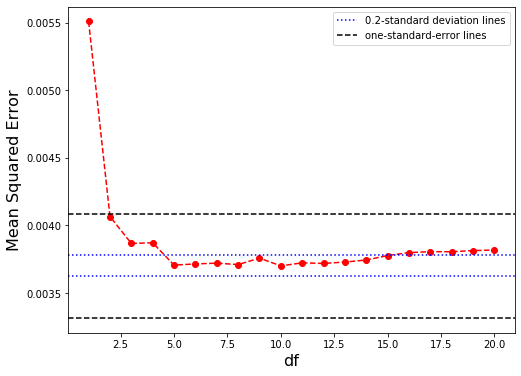

In [13]:
#如果直接使用最小则会产生过拟合的情况，故采用0.2-standard deviation或one-standard-error原则（原理参考6.1.3选择最优模型）
msr_array = np.array(msr_list) 
plt.figure(figsize=(8,6))
plt.plot(range(1,21),msr_list,'r--o')
plt.xlabel('df',fontsize=16)
plt.ylabel('Mean Squared Error',fontsize=16)
plt.axhline(msr_array.min() + msr_array.std() * 0.2,color = 'b',linestyle = ':',label = '0.2-standard deviation lines')
plt.axhline(msr_array.min() - msr_array.std() * 0.2,color = 'b',linestyle = ':')
plt.axhline(msr_array.min() + msr_array.std() * 1,color = 'black',linestyle = '--',label = 'one-standard-error lines')
plt.axhline(msr_array.min() - msr_array.std() * 1,color = 'black',linestyle = '--')
plt.legend()
plt.show()

In [14]:
print('直接取最小值degree为:' , np.argmin(msr_array) + 1)
print('直接取最小值degree为:' , msr_list.index(min(msr_list)) + 1 )

直接取最小值degree为: 10
直接取最小值degree为: 10


one-standard-error选择degree= 2,使用0.2-standard deviation选择degree= 5，最小值为degree= 10